**(Run this cell to define useful Latex macros)**
\\[
\newcommand{\card}[1]{\left\lvert#1\right\rvert}
\newcommand{\condbar}[0]{\,\big|\,}
\newcommand{\eprob}[1]{\widehat{\text{Pr}}\left[#1\right]}
\newcommand{\fpartial}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\ffpartial}[2]{\frac{\partial^2 #1}{\partial {#2}^2}}
\newcommand{\gradient}[0]{\nabla}
\newcommand{\norm}[1]{\left\lvert\left\lvert#1\right\rvert\right\rvert}
\newcommand{\prob}[1]{\text{Pr}\left[#1\right]}
\newcommand{\pprob}[2]{\text{Pr}_{#1}\left[#2\right]}
\newcommand{\set}[1]{\left\{#1\right\}}
\newcommand{\trans}[1]{#1^\mathsf{T}}
\\]

## Lecture 02: Neural Networks

Logistic regression is a form of *linear classification* model. A linear classifier has a linear *decision boundary*. It is probably easiest to explain with an example:

\\[
z(x) = 3 + 5x_1 - 4x_2
\\
f(x) = \sigma(z(x))
\\]

The way the sigmoid function works is $\sigma(z) = \frac{e^z}{1 + e^z}$. Notice that this is 0.5 when $z = 0$, and it is $\sigma(z) < 0.5$ when $z < 0$, and $\sigma(z) > 0.5$ when $z > 0$. Therefore, this function classifies $(x_1, x_2)$ as a positive example when $3 + 5x_1 - 4x_2 > 0$. When this is $< 0$, we classify $(x_1, x_2)$ as negative. What is the *boundary* between these two spaces? What are the points where we think it is equally likely that $(x_1, x_2)$ is a positive or negative example.

\\[
\begin{align}
3 + 5x_1 - 4x_2 &= 0
\\
x_2 = \frac{5}{4}x_1 + \frac{3}{4}
\end{align}
\\]

Let's graph this line to check it out:


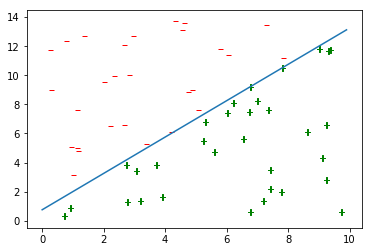

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x_values = np.arange(0, 10, 0.1)
y_values = (5/4) * x_values + 3/4
plt.plot(x_values, y_values, '-')

random_x1s = np.random.uniform(size = 60) * 10
random_x2s = np.random.uniform(size = 60) * 14
classified_positive = ((5/4) * random_x1s + 3/4) > random_x2s
classified_negative = np.logical_not(classified_positive)

plt.scatter(random_x1s[classified_positive], random_x2s[classified_positive], marker = '$+$', color = 'green')
plt.scatter(random_x1s[classified_negative], random_x2s[classified_negative], marker = '$-$', color = 'red')


Not every classification problem can be modeled well with a linear decision boundary:

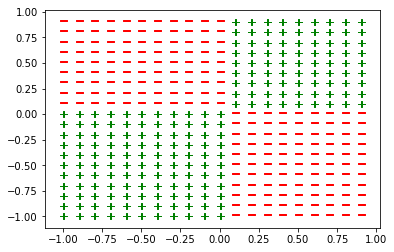

In [2]:
x1s = []
x2s = []
for x1 in np.arange(-1, 1, 0.1):
    for x2 in np.arange(-1, 1, 0.1):
        x1s.append(x1)
        x2s.append(x2)
x1s = np.array(x1s)
x2s = np.array(x2s)

is_positive = x1s * x2s > 0
is_negative = np.logical_not(is_positive)

plt.scatter(
    x1s[is_positive],
    x2s[is_positive],
    marker = '$+$',
    color = 'green',
    s = 60
)
plt.scatter(
    x1s[is_negative],
    x2s[is_negative],
    marker = '$-$',
    color = 'red',
    s = 60
)


Any linear model will suffer a ~50% misclassification rate on this dataset. What kind of dataset looks like this?

Let's say I have two lightswitches for the lights in my room. I want to predict whether the lights are on based on the position of the switch.

If both switches are down, the lights are off. If one is up and the other is down, then the lights are on. If they are both flipped up, then the effect cancels and the lights are off again.

If I was trying to predict whether the lights are on from position of the switches, no linear classifier could do this effectively.

Why? The reason is that the *effect* of "switch 2 is in the up position" changes based on whether "switch 1 is in the down position" versus "in the up position."

Linear models always assume constant effect. In our example $f(x) = \sigma(3 + 5x_1 - 4x_2)$, the impact of $x_1$ is always the same: add 5 to the $z$ value.


Let me show you another model that would solve the XOR problem. We'll use a series of logistic regressions.

\\[
\begin{align}
h_{1, 1} = f_{1, 1}(x_1, x_2) &= \sigma(1000 x_1)
\\
h_{1, 2} = f_{1, 2}(x_1, x_2) &= \sigma(1000 x_2)
\end{align}
\\]

This first pair of functions basically answers: is $x_1 > 0$, is $x_2 > 0$? If $x_1 > 0$, then $f_{1, 1}(x_1, x_2)$ will tend to be very close to one, because $f_{1, 1}$ is very sensitive to $x_1$. I would say we are "soft binarizing" the input, because we are pushing the inputs to zero or to one.

I use the symbols $h_{1, 1}, h_{1, 2}$ to denote the outputs of these functions. I call these the *hidden* values.

Next, let's feed in the hidden values to a next *layer*:

\\[
\begin{align}
h_{2, 1} = f_{2, 1}(h_{1, 1}, h_{1, 2}) &= \sigma\left(
    1000 \left(
        h_{1, 1} - h_{1, 2} - 0.5
    \right)
\right)
\\
h_{2, 2} = f_{2, 2}(h_{1, 1}, h_{1, 2}) &= \sigma\left(
    1000 \left(
        -h_{1, 1} + h_{1, 2} - 0.5
    \right)
\right)
\end{align}
\\]

If $h_1$ is close to zero, then $h_{2, 1}$ has no chance of being close to 1.0. But even if $h_1$ is close to one, we *still* need that $h_2$ is close to zero, else it will *cancel* out the effect of $h_1$. So $h_{2, 1}$ is close to one iff both $h_1$ is close to one AND $h_2$ is close to zero.

The situation for $h_{2, 2}$ is flipped. It is close to one iff $h_{1, 1}$ is close to zero and $h_2$ is close to one.

Finally, we may write:

\\[
\begin{align}
h_{3, 1} = f_{3, 1}(h_{2, 1}, h_{2, 2}) &= \sigma\left(
    1000 \left(
        h_{1, 1} + h_{1, 2} - 0.5
    \right)
\right)
\end{align}
\\]

This outputs one if $h_{2, 1}$ is close to one or $h_{2, 2}$ is close to one.

What we have built is a *network* of logistic regressions that emulates:

\\[
OR(AND(x_1, NOT(x_2)), AND(NOT(x_1, x_2)))
\\]


/Users/ruggeri/.anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


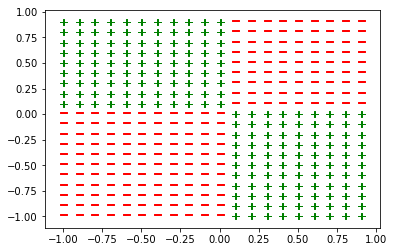

In [3]:
def sigma(x):
    return 1 / (1 + np.exp(-x))

M = 1e3
def classify(x1, x2):
    # Classify is x1 > 0, is x2 > 0?
    h_1_1 = sigma(M * x1)
    h_1_2 = sigma(M * x2)
    
    # Classify is x1 > 0 AND is x2 < 0?
    h_2_1 = sigma(
        M * (h_1_1 - h_1_2 - 0.5)
    )
    # Classify is x1 < 0 AND x2 > 0?
    h_2_2 = sigma(
        M * (-h_1_1 + h_1_2 - 0.5)
    )

    # Classify does x1 != x2
    h_3_1 = sigma(
        M * (h_2_1 + h_2_2 - 0.5)
    )

    return h_3_1 > 0.5

x1s = []
x2s = []
for x1 in np.arange(-1, 1, 0.1):
    for x2 in np.arange(-1, 1, 0.1):
        x1s.append(x1)
        x2s.append(x2)
x1s = np.array(x1s)
x2s = np.array(x2s)

classified_positive = classify(x1s, x2s)
classified_negative = np.logical_not(classified_positive)

plt.scatter(
    x1s[classified_positive],
    x2s[classified_positive],
    marker = '$+$',
    color = 'green',
    s = 60
)
plt.scatter(
    x1s[classified_negative],
    x2s[classified_negative],
    marker = '$-$',
    color = 'red',
    s = 60
)


What we are seeing here is that we an learn a much more sophisticated, nonlinear decision boundary if we have *layers* of logistic regressions, and with more than one logistic regression being performed at each layer.

This is exactly what a neural network is. It is just layers of logistic regressions.

![](./images/02a_neural_net_diagram.jpg)

In the above diagram, I have written constants like 1000 and 0.5 into the equations. I will now introduce some symbols to stand for those. Here are the first two layers of the network:

![](./images/02b_neural_net_matrices.jpg)

We call $W^{(1)}$ and $W^{(2)}$ *weight matrices*. We call $b^{(1)}$ and $b^{(2)}$ *bias vectors*.

In this context, the function $\sigma$ is sometimes called the *activation function*. We often use alternatives to $\sigma$ as activation functions. We'll learn about the relu and tanh functions later on.

The vectors $h^{(1)}, h^{(2)}$ are called hidden activations. Each value in a hidden activation vector can be thought of as a "node" or "unit." The unit $h^{(2)}_i$ takes as input all the prior layer's activations $h^{(1)}$, weights them with $W^{(2)}_{i, :}$ (that is, the $i$th row of $W^{(2)}$), and then adds in the bias $b^{(2)}_i$.

Calculating all the $h^{(i)}$ up to the end is called performing a *forward pass*.

Neural networks are much more powerful than logistic regression. While logistic regression can only learn a linear decision boundary, neural networks can in theory learn almost any kind of decision boundary. If you're interested in some math you can look up the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem).

The only downside is that neural networks may need to have many, many hidden units to approximate a boundary. So you may need a very complex neural network to model a complicated decision boundary.

The number of *layers* of hidden units is called the *depth* of the network. In theory, a network with a single hidden layer can represent any decision boundary, provided that the hidden layer has enough units. Adding additional layers in theory doesn't increase the *power* of neural networks: any boundary that can be learned by a network with three hidden layers can be learned by a network with only one.

However, it may be much more *efficient* to use multiple hidden layers. For instance, a boundary that might be learnable with a single hidden layer of one million units could (potentially) be learned in three layers of one hundred units. More layers won't *always* help, but they often do. The fewer overall number of units your network uses, the faster it will be to train the network, and the less data which will be needed to train it.

Each hidden layer of a network is like a *level of abstraction*. Abstractions help us efficiently organize our perceptions and experiences. When I look at a photo of a cat and recognize that a cat is in the photo, I do this through several levels of abstraction. First I see the pixels of the photo. But then I look for lines and curves in the photo. Then I see the shapes and regions bounded by those lines. Some of those shapes will look like parts of a cat: legs, tail, face. I may then even abstract further: this is a photo of my cat Markov!

Each level of representation is more general and high-level. Each level is a new way of "seeing" the cat. At each level, we tend to use fewer words to describe the photo, but each word is "denser in meaning." Saying "the intensity of the green channel at pixel 123 is 0.7" is much more specific and less meaningful than saying "in the left corner of the photo there is a cat's leg."

Hopefully this gives some intuition why it helps to add additional hidden layers to a neural network. In the next lecture we'll talk about some disadvantages.
